#### Exercise 4: Discrete Event Simulation

####  Discrete Event Simulation of a Blocking System

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.stats import t
from scipy import stats

#### Write a discrete event simulation program for a blocking system, i.e. a system with m service units and no waiting room. The offered traffic A is the product of the mean arrival rate and the mean service time.

#### 1. The arrival process is modelled as a Poisson process. Report the fraction of blocked customers, and a confidence interval for this fraction. Choose the service time distribution as exponential. Parameters: m = 10, mean service time = 8 time units, mean time between customers = 1 time unit (corresponding to an offered traffic of 8 Erlang), 10 x 10.000 customers. This system is sufficiently simple such that the analytical solution is known. See the last slide for the solution. Verify your simulation program using this knowledge.

The blocking probability is given by 

$$
B = \frac{ A^{m} / m ! }{ \sum_{i=0}^{m} \frac{A^{i}}{i!} }
$$

where $A$ is the product of the mean arrival rate $\lambda$ and the mean service time $s$, i.e. $A = \lambda s$. It can be thought of as probability of lost sales, etc.

#### Fraction of blocked customers - Analytic solution

In [223]:
# --- Parameters ---
m = 10              # No. of service units / number of sub-samples
s = 8               # mean service time 
l = 1               # mean arrival rate  λ (1 customer per unit time)
mean_interarrival = 1 / l
n = 10000           # number of customers per run 
r = 10              # number of simulation runs
np.random.seed(42)
A = l * s 

# Erlang’s B-formula
B = (A**m / math.factorial(m)) / sum((A**i)/math.factorial(i) for i in range (m+1))

# Compute blocking probability
print(f"The analytical solution for a blocking system (Erlang B): {B:.5f}")

The analytical solution for a blocking system (Erlang B): 0.12166


#### Fraction of blocked customers - Simulation method

In [160]:
def simulate_blocking_system(m, s, mean_interarrival, n, r):
    blocked_customers = []

    for _ in range(r):
        num_blocked = 0
        busy_servers = 0
        current_time = 0

        # The arrival process interarrival times (Poisson process)
        inter_arrival_times = np.random.exponential(mean_interarrival, n)
        arrival_times = np.cumsum(inter_arrival_times)

        # Service time distribution as exponential
        service_times = np.random.exponential(s, n)
        departure_times = np.zeros(n)

        # Event queue
        events = [(arrival_times[i], 'arriving', i) for i in range(n)]
        events.sort() # chronological sorting

        for e in events:
            event_time, event_type, customer_index = e
            current_time = event_time

            if event_type == 'arriving':
                if busy_servers < m:
                    busy_servers += 1
                    departure_time = current_time + service_times[customer_index]
                    departure_times[customer_index] = departure_time
                    events.append((departure_time, 'departing', customer_index))
                    events.sort() # Re-sort events after adding a departure
                    #print(events)
                else:
                    num_blocked += 1
            elif event_type == 'departing':
                busy_servers -= 1

        blocked_customers.append(num_blocked)

    return np.array(blocked_customers)

# --- Run Simulation ---
blocked_customers = simulate_blocking_system(m, s, 1/l, n, r)


In [162]:
# Calculate the fraction of blocked customers
mean_blocking_percentage = np.mean(blocked_customers) / n

print(f"Fraction of blocked customers (simulation method): {mean_blocking_percentage:.4f}")

Fraction of blocked customers (simulation method): 0.1233


#### Confidence interval of the blocking probability

The confidence interval for the blocking probability can be given by first obtaining $n$ different (independent) estimates of the blocking probabilities and then calculating their mean and variance.

$$
\bar{\theta} = \frac{ \sum_{i=1}^{n} \hat{\theta}_{i} }{ n } \hspace{0.3cm} , \hspace{0.3cm} S_{\theta}^{2} = \frac{1}{n-1} \left(  \sum_{i=1}^{n} \hat{\theta}_{i}^{2} - n \bar{\theta}^2 \right)
$$

The $(1 - \alpha)$% CI is then

$$
\left[ \bar{\theta} - \frac{ S_{\theta} }{ \sqrt{n} } t_{\alpha/2} (n - 1) ; \bar{\theta} + \frac{ S_{\theta} }{ \sqrt{n} } t_{1 - \alpha/2} (n - 1) \right]
$$

Note that the service time and arrival rate are sampled from the exponential distribution.

Note that the mean service time $s$ means that the rate would be $\lambda_{s} = \frac{1}{s}$ and the mean arrival rate is as given, $\lambda$. When sampling from the exponential distribution the argument requires that we input the inverse of the rate parameter but when sampling from the Poisson distribution the argument requires that we input the rate parameter.


In [166]:
from scipy import stats

In [167]:
# number of runs
r = len(blocked_customers)

# convert counts to probabilities per run
theta_hat = blocked_customers / n   # if 'n' is the total offered customers
#print(f"Theta hat     : {theta_hat}")

# sample mean
theta_bar = np.sum(theta_hat) / r
#theta_bar  = np.mean(theta_hat)

# sample variance via the formula you gave
S2 = (np.sum(theta_hat**2) - r * theta_bar**2) / (r - 1)
#S2         = np.var(theta_hat, ddof=1)
S = np.sqrt(S2)

print(f"Mean blocking probability     : {theta_bar:.6f}")
print(f"Sample variance (of estimates): {S2:.6e}")

# Obtain alpha/2 and 1-alpha/2 quantile from t-distribution '

# Obtain t
alpha = 0.05 #significance level 5% , so we're constructing a 95% confidence interval (CI)
df = r - 1 #degrees of freedom
t_lower = t.ppf(alpha / 2, df) #  critical t-value = -2.26
t_upper = t.ppf(1 - alpha / 2, df) #  critical t-value = 2.26

lower = theta_bar + ( S / np.sqrt(r) ) * t_lower
upper = theta_bar + ( S / np.sqrt(r) ) * t_upper

print(f"The 95% CI for the fraction of blocked customers per the simulation is: \n [{lower:.4f}, {upper:.4f}]")


Mean blocking probability     : 0.121470
Sample variance (of estimates): 2.984900e-05
The 95% CI for the fraction of blocked customers per the simulation is: 
 [0.1176, 0.1254]


#### 2. The arrival process is modelled as a renewal process using the same parameters as in Part 1 when possible. Report the fraction of blocked customers, and a confidence interval for this fraction for at least the following two cases

#### (a) Experiment with Erlang distributed inter arrival times The Erlang distribution should have a mean of 1

Change the arrival process to generate arrival times from the Erlang distribution

In [ ]:
def simulate_blocking_system_erlang(m, s, mean_interarrival, n, r):
    blocked_customers = []

    for _ in range(r):
        num_blocked = 0
        busy_servers = 0
        current_time = 0

        # The arrival process interarrival times (Erlang distribution)
        inter_arrival_times = np.random.exponential(mean_interarrival, n)


        # inter_arrival_times = np.random.poisson(arrival_time, n)
        arrival_times = np.cumsum(inter_arrival_times)

        # Rervice time distribution as exponential
        service_times = np.random.exponential(s, n)
        departure_times = np.zeros(n)

        # Event queue
        events = [(arrival_times[i], 'arriving', i) for i in range(n)]
        events.sort()

        for e in events:
            event_time, event_type, customer_index = e
            current_time = event_time

            if event_type == 'arriving':
                if busy_servers < m:
                    busy_servers += 1
                    departure_time = current_time + service_times[customer_index]
                    departure_times[customer_index] = departure_time
                    events.append((departure_time, 'departing', customer_index))
                    events.sort() # Re-sort events after adding a departure
                else:
                    num_blocked += 1
            elif event_type == 'departing':
                busy_servers -= 1

        blocked_customers.append(num_blocked)

    return np.array(blocked_customers)

# --- Run Simulation ---
blocked_customers = simulate_blocking_system_erlang(m, s, 1/l, n, r)
blocked_fraction = blocked_customers / n

[0.1248 0.1203 0.116  0.1263 0.1282 0.116  0.134  0.1221 0.1189 0.1299]


In [184]:
# Calculate the fraction of blocked customers
mean_blocking_percentage = np.mean(blocked_customers) / n

print(f"Fraction of blocked customers (simulation method): {mean_blocking_percentage:.4f}")

Fraction of blocked customers (simulation method): 0.1190


In [185]:
# number of runs
r = len(blocked_customers)

# convert counts to probabilities per run
theta_hat = blocked_customers / n   # if 'n' is the total offered customers
#print(f"Theta hat     : {theta_hat}")

# sample mean
theta_bar = np.sum(theta_hat) / r
#theta_bar  = np.mean(theta_hat)

# sample variance via the formula you gave
S2 = (np.sum(theta_hat**2) - r * theta_bar**2) / (r - 1)
#S2         = np.var(theta_hat, ddof=1)
S = np.sqrt(S2)

print(f"Mean blocking probability     : {theta_bar:.6f}")
print(f"Sample variance (of estimates): {S2:.6e}")

# Obtain alpha/2 and 1-alpha/2 quantile from t-distribution '

# Obtain t
alpha = 0.05 #significance level 5% , so we're constructing a 95% confidence interval (CI)
df = r - 1 #degrees of freedom
t_lower = t.ppf(alpha / 2, df) #  critical t-value = -2.26
t_upper = t.ppf(1 - alpha / 2, df) #  critical t-value = 2.26

lower = theta_bar + ( S / np.sqrt(r) ) * t_lower
upper = theta_bar + ( S / np.sqrt(r) ) * t_upper

print(f"The 95% CI for the fraction of blocked customers per the simulation is: \n [{lower:.4f}, {upper:.4f}]")

Mean blocking probability     : 0.119000
Sample variance (of estimates): 1.745111e-05
The 95% CI for the fraction of blocked customers per the simulation is: 
 [0.1160, 0.1220]


#### (b) hyper exponential inter arrival times. The parameters for the hyper exponential distribution should be 
$$
p_{1} = 0.8, \lambda_{1} = 0.8333, p_{2} = 0.2, \lambda_{2} = 5.0
$$


The hyperexponential distribution has the probability density function given by

$$
f_{X}(x) = \sum_{i=1}^{n} f_{Y_{i}}(x) p_{i}
$$

where $f_{Y_{i}}(x)$ is an exponential distributed random variable with the rate parameters as given.


In [186]:
def hyperexp_distribution(lambda1, lambda2, p1, p2, n):
    # Obtain f_Y1(x)
    f_Y1 = np.random.exponential(1/lambda1, n)

    # Obtain f_Y2(x)
    f_Y2 = np.random.exponential(1/lambda2, n)

    # Obtain f_X which are the arrivals
    f_X = f_Y1 * p1 + f_Y2 * p2
    arrivals = f_X
    
    return arrivals

In [187]:
def simulate_blocking_system_hyperexp(m, s, mean_interarrival, n, r):
    blocked_customers = []

    for _ in range(r):
        num_blocked = 0
        busy_servers = 0
        current_time = 0

        # The arrival process interarrival times (Poisson process)
        inter_arrival_times = hyperexp_distribution(lambda1=0.8333, lambda2=5.0, p1=0.8, p2=0.2, n=10000)
 
        # inter_arrival_times = np.random.poisson(arrival_time, n)
        arrival_times = np.cumsum(inter_arrival_times)

        # Rervice time distribution as exponential
        service_times = np.random.exponential(s, n)
        departure_times = np.zeros(n)

        # Event queue
        events = [(arrival_times[i], 'arriving', i) for i in range(n)]
        events.sort()

        for e in events:
            event_time, event_type, customer_index = e
            current_time = event_time

            if event_type == 'arriving':
                if busy_servers < m:
                    busy_servers += 1
                    departure_time = current_time + service_times[customer_index]
                    departure_times[customer_index] = departure_time
                    events.append((departure_time, 'departing', customer_index))
                    events.sort() # Re-sort events after adding a departure
                else:
                    num_blocked += 1
            elif event_type == 'departing':
                busy_servers -= 1

        blocked_customers.append(num_blocked)

    return np.array(blocked_customers)

# --- Run Simulation ---
# No. of runs
r = 10
blocked_customers = simulate_blocking_system_hyperexp(m, s, 1/l, n, r)
blocked_fraction = blocked_customers / n



In [188]:
# number of runs
r = len(blocked_customers)

# convert counts to probabilities per run
theta_hat = blocked_customers / n   # if 'n' is the total offered customers
#print(f"Theta hat     : {theta_hat}")

# sample mean
theta_bar = np.sum(theta_hat) / r
#theta_bar  = np.mean(theta_hat)

# sample variance via the formula you gave
S2 = (np.sum(theta_hat**2) - r * theta_bar**2) / (r - 1)
#S2         = np.var(theta_hat, ddof=1)
S = np.sqrt(S2)

print(f"Mean blocking probability     : {theta_bar:.6f}")
print(f"Sample variance (of estimates): {S2:.6e}")

# Obtain alpha/2 and 1-alpha/2 quantile from t-distribution '

# Obtain t
alpha = 0.05 #significance level 5% , so we're constructing a 95% confidence interval (CI)
df = r - 1 #degrees of freedom
t_lower = t.ppf(alpha / 2, df) #  critical t-value = -2.26
t_upper = t.ppf(1 - alpha / 2, df) #  critical t-value = 2.26

lower = theta_bar + ( S / np.sqrt(r) ) * t_lower
upper = theta_bar + ( S / np.sqrt(r) ) * t_upper

print(f"The 95% CI for the fraction of blocked customers per the simulation is: \n [{lower:.4f}, {upper:.4f}]")

Mean blocking probability     : 0.115210
Sample variance (of estimates): 1.362322e-05
The 95% CI for the fraction of blocked customers per the simulation is: 
 [0.1126, 0.1179]


#### 3. The arrival process is again a Poisson process like in Part 1. Experiment with different service time distributions with the same mean service time and m as in Part 1 and Part 2.

#### (a) Constant service time

The service time is now simply 'mean service time' = 8 * units for every customer.

service_times = s * np.ones(n)

In [213]:
def simulate_blocking_system_cons(m, s, mean_interarrival, n, r):
    blocked_customers = []

    for _ in range(r):
        num_blocked = 0
        busy_servers = 0
        current_time = 0

        # The arrival process interarrival times (Poisson process)
        inter_arrival_times = np.random.exponential(mean_interarrival, n)
        arrival_times = np.cumsum(inter_arrival_times)

        # Service times constant
        service_times = s * np.ones(n)
        departure_times = np.zeros(n)

        # Event queue
        events = [(arrival_times[i], 'arriving', i) for i in range(n)]
        events.sort()

        for e in events:
            event_time, event_type, customer_index = e
            current_time = event_time

            if event_type == 'arriving':
                if busy_servers < m:
                    busy_servers += 1
                    departure_time = current_time + service_times[customer_index]
                    departure_times[customer_index] = departure_time
                    events.append((departure_time, 'departing', customer_index))
                    events.sort() # Re-sort events after adding a departure
                else:
                    num_blocked += 1
            elif event_type == 'departing':
                busy_servers -= 1

        blocked_customers.append(num_blocked)

    return np.array(blocked_customers)

# --- Run Simulation ---

# No. of runs
r = 10

blocked_customers = simulate_blocking_system_cons(m, s, 1/l, n, r)
blocked_fraction = blocked_customers / n

In [214]:
# number of runs
r = len(blocked_customers)

# convert counts to probabilities per run
theta_hat = blocked_customers / n   # if 'n' is the total offered customers
#print(f"Theta hat     : {theta_hat}")

# sample mean
theta_bar = np.sum(theta_hat) / r
#theta_bar  = np.mean(theta_hat)

# sample variance via the formula you gave
S2 = (np.sum(theta_hat**2) - r * theta_bar**2) / (r - 1)
#S2         = np.var(theta_hat, ddof=1)
S = np.sqrt(S2)

print(f"Mean blocking probability     : {theta_bar:.6f}")
print(f"Sample variance (of estimates): {S2:.6e}")

# Obtain alpha/2 and 1-alpha/2 quantile from t-distribution '

# Obtain t
alpha = 0.05 #significance level 5% , so we're constructing a 95% confidence interval (CI)
df = r - 1 #degrees of freedom
t_lower = t.ppf(alpha / 2, df) #  critical t-value = -2.26
t_upper = t.ppf(1 - alpha / 2, df) #  critical t-value = 2.26

lower = theta_bar + ( S / np.sqrt(r) ) * t_lower
upper = theta_bar + ( S / np.sqrt(r) ) * t_upper

print(f"The 95% CI for the fraction of blocked customers per the simulation is: \n [{lower:.4f}, {upper:.4f}]")

Mean blocking probability     : 0.122690
Sample variance (of estimates): 2.956544e-05
The 95% CI for the fraction of blocked customers per the simulation is: 
 [0.1188, 0.1266]


#### (b) Pareto distributed service times with at least k = 1.05 and k = 2.05.

In [ ]:
# Generate Pareto samples for k=1.05, k=2.05

# k = [1.05, 2.05]
# samples = np.zeros((n, len(k)))
# for i in range(len(k)):
# pareto_samples = np.random.pareto(k[i], n)
# samples[:,i] = pareto_samples

In [ ]:

def simulate_blocking_system_pareto(m, s, arrival_time, n, r, k):
    blocked_customers = []

    for _ in range(r):
        
        num_blocked = 0
        busy_servers = 0
        current_time = 0
        
        # The arrival process interarrival times (Poisson process)
        inter_arrival_times = np.random.exponential(mean_interarrival, n)
        arrival_times = np.cumsum(inter_arrival_times)
        
        # Generate service times from pareto distribution
        #service_times = np.random.pareto(k=1.05, n)
  

        # Generate pareto service times via inverse‐transform
        beta = 1
        U    = np.random.uniform(0, 1, n)
        service_times = beta * U**(-1/k)
        
        departure_times = np.zeros(n)
        
        # Event queue
        events = []
        
        for i in range(n):
            events.append((arrival_times[i], 'arriving', i))
        
        # Sort events per time
        events.sort() 

        for e in events:
            event_time, event_type, customer_index = e
            current_time = event_time

            if event_type == 'arriving':
                if busy_servers < m:
                    
                    busy_servers += 1
                    departure_time = current_time + service_times[customer_index]
                    departure_times[customer_index] = departure_time
                    events.append((departure_time, 'departing', customer_index))
                    
                    # Re-sort events after adding a departure
                    events.sort()
                else:
                    num_blocked += 1
            elif event_type == 'departing':
                busy_servers -= 1

        blocked_customers.append(num_blocked)

    return np.array(blocked_customers)

# No. of runs
r = 10

# Simulate to obtain no. of blocked customers
k = np.array([1.05, 2.05])
blocked_customers = np.zeros((r, len(k)))

for i in range(len(k)):
    blocked = simulate_blocking_system_pareto(m, s, 1/l, n, r, k[i])
    blocked_customers[:,i] = blocked

IndentationError: expected an indented block after 'for' statement on line 20 (2142997677.py, line 21)

#### (c) Choose one or two other distributions.

We can try with the log-normal distribution for the service times. We let $\mathrm{E}(X)=8$ and $\mathrm{Var}(x)=1$ (assumption). We get $\mu$ and $\sigma$ for the log-normal distribution as

$$
\mu = \ln \left( \frac{\mathrm{E}(x)^{2}}{\sqrt{\mathrm{E}(x)^{2} + \mathrm{Var}(x)^{2}}} \right) \hspace{0.3cm} , \hspace{0.3cm} \sigma^2 = \ln\left( 1 + \frac{\mathrm{Var}(X)}{\mathrm{E}(X)^2} \right)
$$ 


In [226]:
def simulate_blocking_system_lognorm(m, s, arrival_time, n, r):
    blocked_customers = []

    for _ in range(r):
        
        num_blocked = 0
        busy_servers = 0
        current_time = 0

        # The arrival process interarrival times (Poisson process)
        inter_arrival_times = np.random.exponential(mean_interarrival, n)
        arrival_times = np.cumsum(inter_arrival_times)
        
        # Assuming a reasonable variance to calculate parameters (for log-normal distrubtion)
        var = 1 # Assumption
        
        # Calculate mu and sigma for the underlying normal distribution
        mu = np.log(s**2 / np.sqrt(var + s**2))
        sigma = np.sqrt(np.log(var / s**2 + 1))
        
        # Generate service times from log-normal distribution
        service_times = np.random.lognormal(mu, sigma, n)
        
        departure_times = np.zeros(n)
        
        # Event queue
        events = []
        
        for i in range(n):
            events.append((arrival_times[i], 'arriving', i))
        
        # Sort events per time
        events.sort() 

        for e in events:
            event_time, event_type, customer_index = e
            current_time = event_time

            if event_type == 'arriving':
                if busy_servers < m:
                    
                    busy_servers += 1
                    departure_time = current_time + service_times[customer_index]
                    departure_times[customer_index] = departure_time
                    events.append((departure_time, 'departing', customer_index))
                    
                    # Re-sort events after adding a departure
                    events.sort()
                else:
                    num_blocked += 1
            elif event_type == 'departing':
                busy_servers -= 1

        blocked_customers.append(num_blocked)

    return blocked_customers

# No. of runs
r = 10

# Simulate to obtain no. of blocked customers
blocked_customers = simulate_blocking_system_lognorm(m, s, 1/l, n, r)

In [ ]:
# number of runs
r = len(blocked_customers)

# convert counts to probabilities per run
theta_hat = blocked_customers / n   # if 'n' is the total offered customers
#print(f"Theta hat     : {theta_hat}")

# sample mean
theta_bar = np.sum(theta_hat) / r
#theta_bar  = np.mean(theta_hat)

# sample variance via the formula you gave
S2 = (np.sum(theta_hat**2) - r * theta_bar**2) / (r - 1)
#S2         = np.var(theta_hat, ddof=1)
S = np.sqrt(S2)

print(f"Mean blocking probability     : {theta_bar:.6f}")
print(f"Sample variance (of estimates): {S2:.6e}")

# Obtain alpha/2 and 1-alpha/2 quantile from t-distribution '

# Obtain t
alpha = 0.05 #significance level 5% , so we're constructing a 95% confidence interval (CI)
df = r - 1 #degrees of freedom
t_lower = t.ppf(alpha / 2, df) #  critical t-value = -2.26
t_upper = t.ppf(1 - alpha / 2, df) #  critical t-value = 2.26

lower = theta_bar + ( S / np.sqrt(r) ) * t_lower
upper = theta_bar + ( S / np.sqrt(r) ) * t_upper

print(f"The 95% CI for the fraction of blocked customers per the simulation is: \n [{lower:.4f}, {upper:.4f}]")

TypeError: unsupported operand type(s) for /: 'list' and 'int'

#### 4. Compare confidence intervals for Parts 1, 2, and 3 then interpret and explain differences if any.

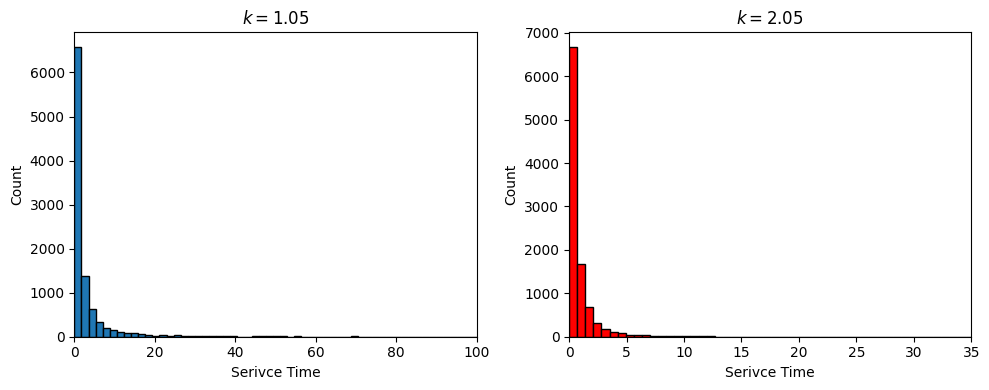

In [229]:
# Generate Pareto samples for k=1.05, k=2.05
n = 10000
k = [1.05, 2.05]
samples = np.zeros((n, len(k)))
for i in range(len(k)):
    pareto_samples = np.random.pareto(k[i], n)
    samples[:,i] = pareto_samples

# Plotting
plt.subplots(1,2, figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(samples[:,0], bins=2500, edgecolor='black')
plt.xlim(0, 100)
plt.xlabel('Serivce Time')
plt.ylabel('Count')
plt.title(r'$k=1.05$')

plt.subplot(1,2,2)
plt.hist(samples[:,1], bins=180, color='red', edgecolor='black')
plt.xlim(0, 35)
plt.xlabel('Serivce Time')
plt.ylabel('Count')
plt.title(r'$k=2.05$')

plt.tight_layout()
plt.show()
